# Welcome to Simple-Linear-Regression-from-Scratch Notebook. 
I am Amulya Jain, Aspirig ML Engineer, I am learning cool things and therefore in the journey to share and learn in public continuously. I am open to improvements and positive critism, would appreciate upvotes and feedback !!
Happy Learning :) 

## In this notebook, We will apply Linear Regression Model on this Data by following Machine Learning Steps and apply all techniques from scratch.

## Installing Dependencies for Computation and Visualization

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/headbraincsv/headbrain.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0,10.0)
import pickle

## Loading the Dataset

In [3]:
## Dataframe
df = pd.read_csv('/kaggle/input/headbraincsv/headbrain.csv') 
df

,Gender,Age Range,Head Size(cm^3),Brain Weight(grams)
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590
...,...,...,...,...
232,2,2,3214,1110
233,2,2,3394,1215
234,2,2,3233,1104
235,2,2,3352,1170


## Basic Description of the Dataset

In [4]:
## Shape of the dataset (Rows, Columns)
df.shape

(237, 4)

In [5]:
## Information about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Gender               237 non-null    int64
 1   Age Range            237 non-null    int64
 2   Head Size(cm^3)      237 non-null    int64
 3   Brain Weight(grams)  237 non-null    int64
dtypes: int64(4)
memory usage: 7.5 KB


#### We notice ```Not-Null Count``` and observe that good thing is that there is no column, which has null values.

In [6]:
df.describe()

,Gender,Age Range,Head Size(cm^3),Brain Weight(grams)
count,237.000000,237.000000,237.000000,237.000000
mean,1.434599,1.535865,3633.991561,1282.873418
std,0.496753,0.499768,365.261422,120.340446
min,1.000000,1.000000,2720.000000,955.000000
25%,1.000000,1.000000,3389.000000,1207.000000
50%,1.000000,2.000000,3614.000000,1280.000000
75%,2.000000,2.000000,3876.000000,1350.000000
max,2.000000,2.000000,4747.000000,1635.000000


#### Basic Statistics from describe tell us that stats about the data in the column.

## Basic Plots to understand the data

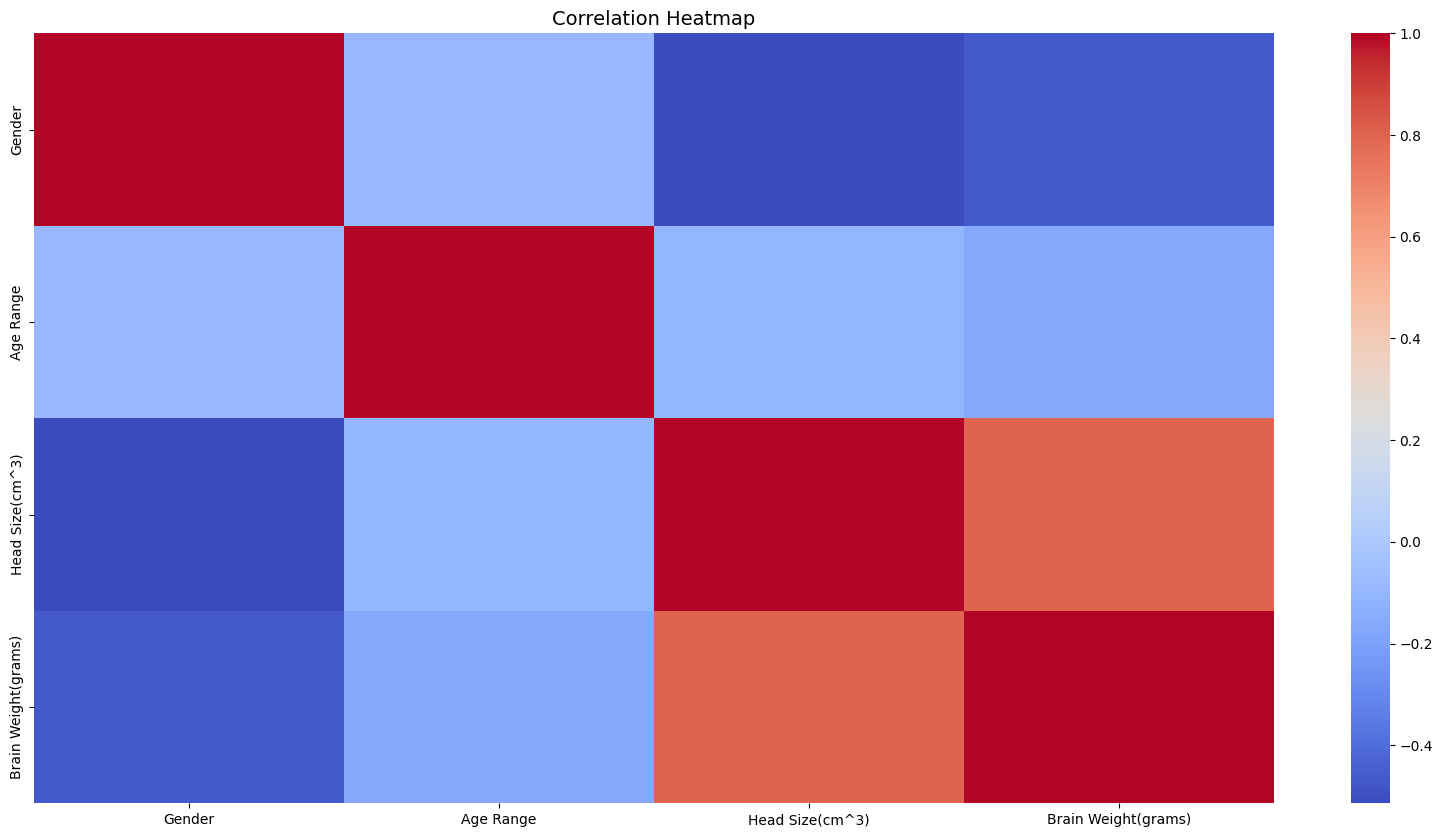

In [7]:
## Correlation matrix
corr = df.corr(numeric_only=True)  # numeric_only avoids errors if strings exist

sns.heatmap(corr, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

#### We observe the 2 blocks x 2 blocks, 4 red blocks at the bottom right and other blue ones indicating:
1. Head Size (cm³) and Brain Weight (grams) have a strong positive correlation (≈ 0.8+).
    - This means head size is a good predictor for brain weight in a linear model.
2. Gender and Age Range have very low correlations (close to 0 or slightly negative) with brain weight.
    - In simple linear regression, features with low correlation to the target won’t help much.
    - In multiple linear regression, they might still help if they interact with other features (but here, likely minimal impact).

#### Now, below are some boxplots to see if there exists outliers which would affect our model learning.

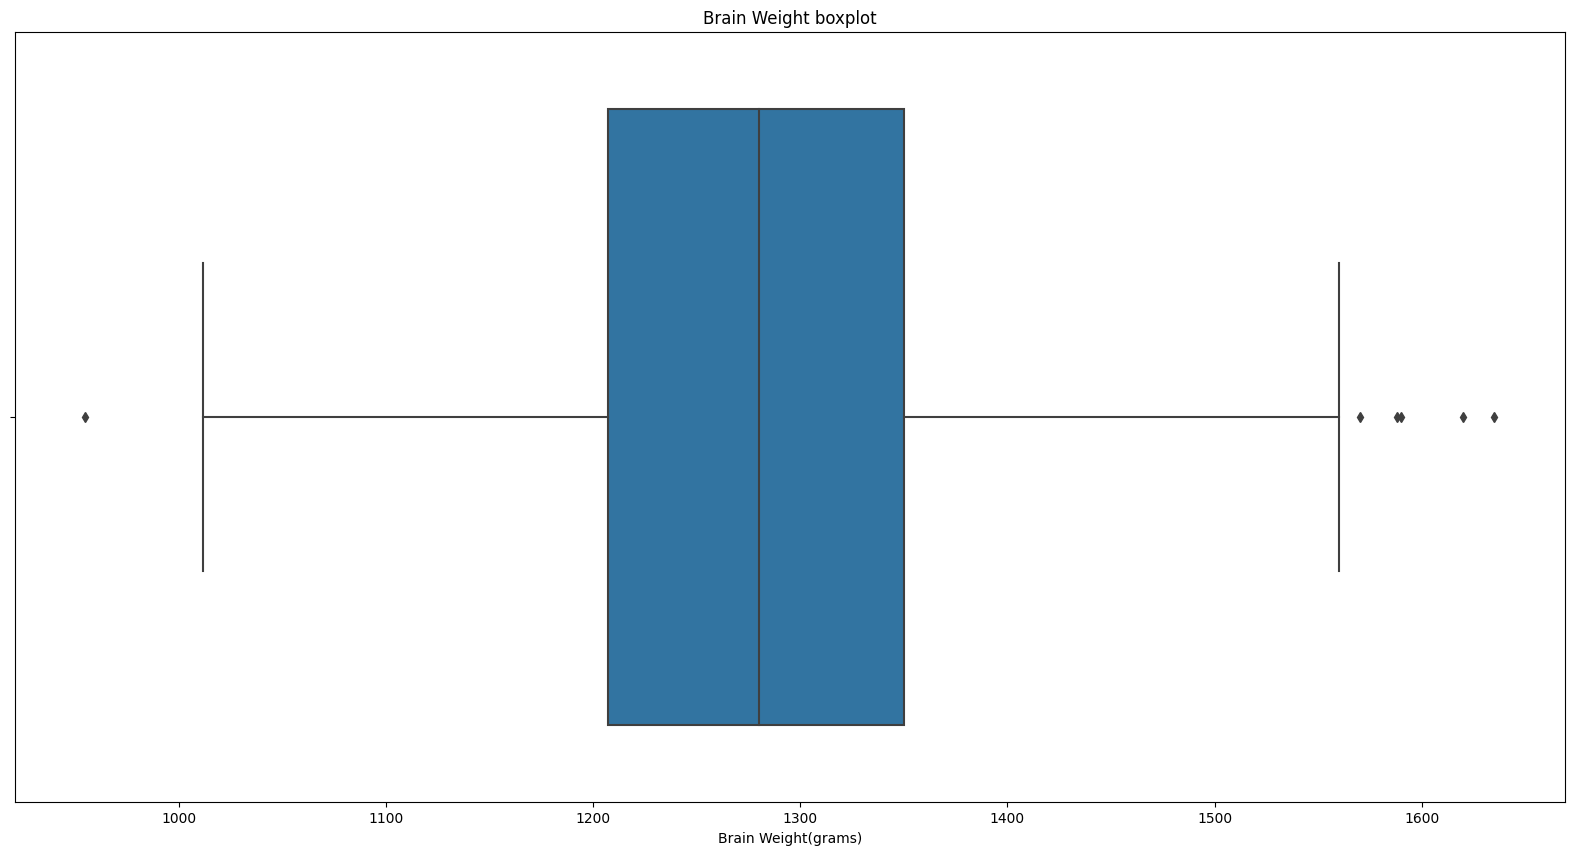

In [8]:
## Box plot of Brain Weight
sns.boxplot(x="Brain Weight(grams)", data=df)
plt.title("Brain Weight boxplot")
plt.show()

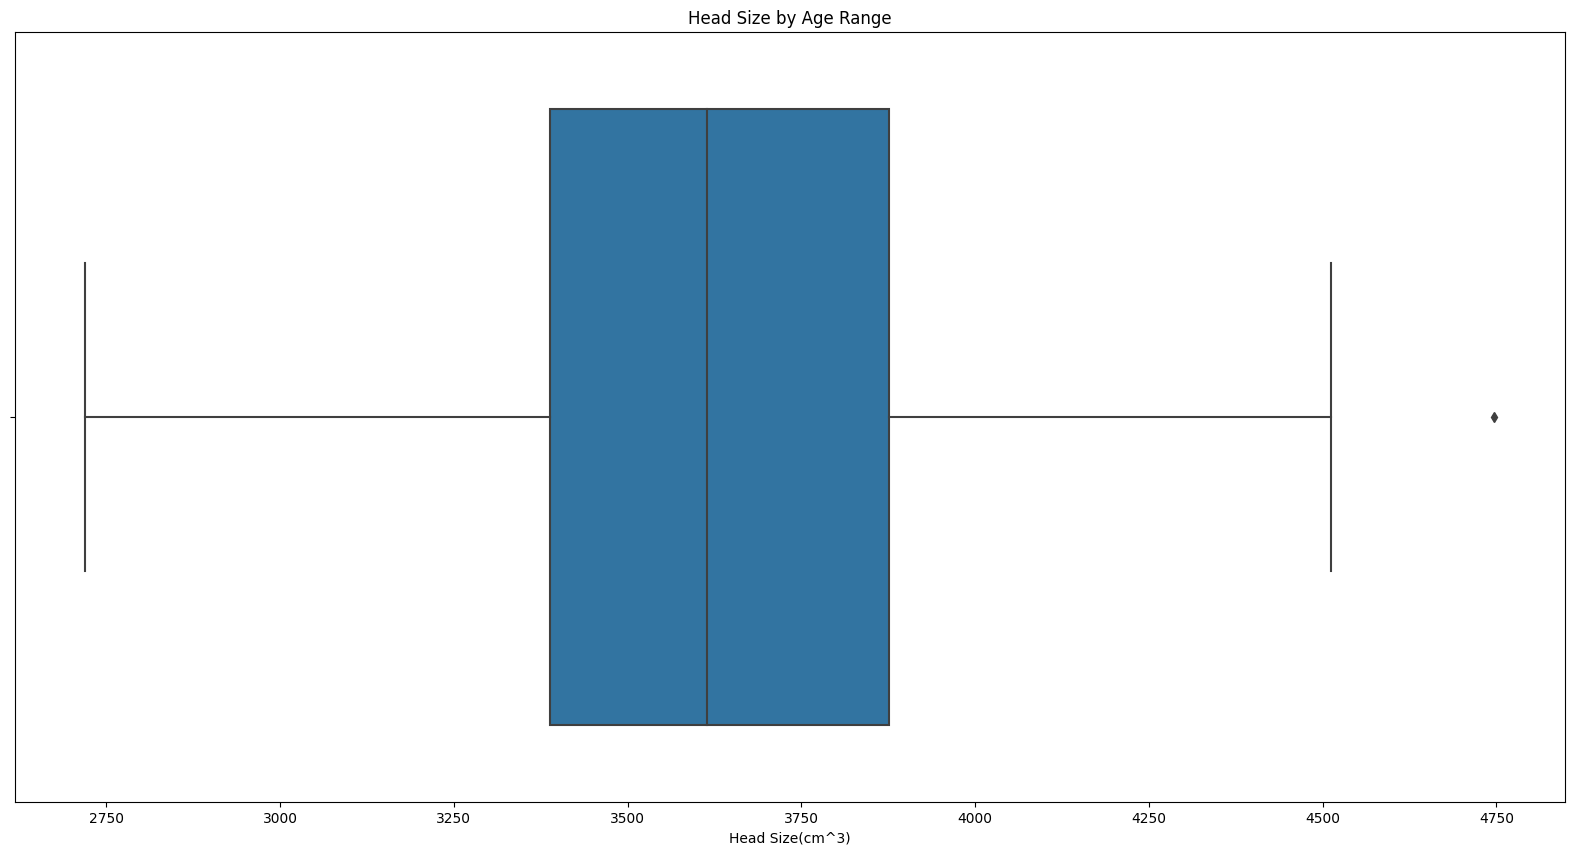

In [9]:
## Box plot of Head Size
sns.boxplot(x="Head Size(cm^3)", data=df)
plt.title("Head Size by Age Range")
plt.show()

#### We see, there are some outliers (those tiny points beyond the distribution of the plots) in both features (columns), so before that we should also keep in mind certain points:
1. Since our dataset is small and probably not perfectly normal, I’d perform IQR because it is robust to small datasets and also works well for skewed data but we can do z-score also.
2. Removing true noise can improve our model performance metrics when we will do it.
3. But if those “outliers” are valid measurements, removing them may reduce generalization.

In [10]:
def remove_outliers_iqr(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [11]:
df_clean = remove_outliers_iqr(df, "Head Size(cm^3)")
df_clean = remove_outliers_iqr(df_clean, "Brain Weight(grams)")

print("Original:", df.shape)
print("After removing outliers:", df_clean.shape)

Original: (237, 4)
After removing outliers: (231, 4)


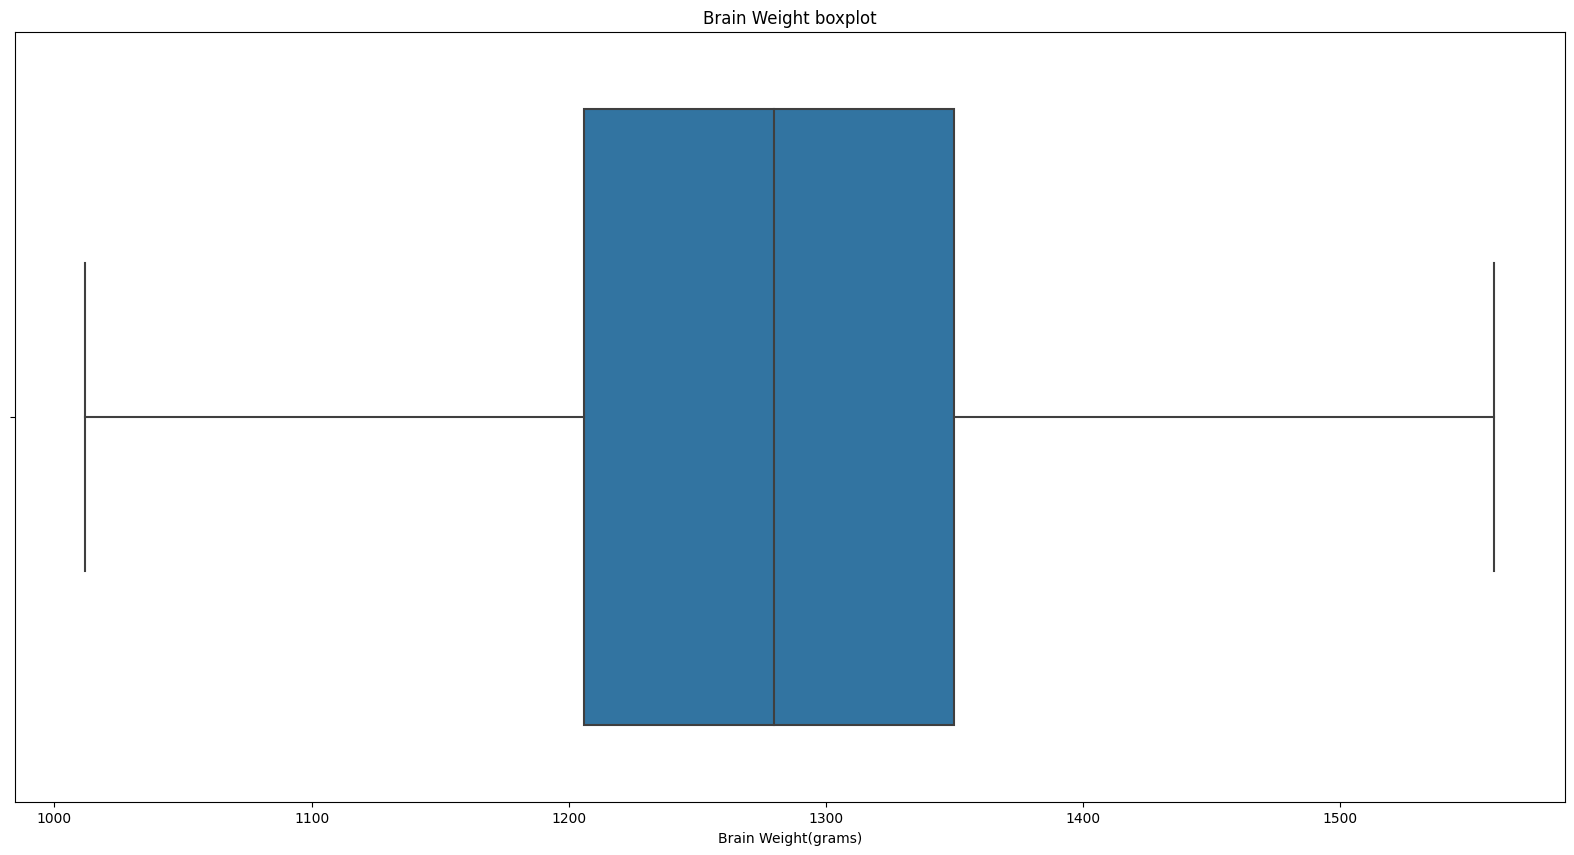

In [12]:
## Box plot of Brain Weight after IQR
sns.boxplot(x="Brain Weight(grams)", data=df_clean)
plt.title("Brain Weight boxplot")
plt.show()

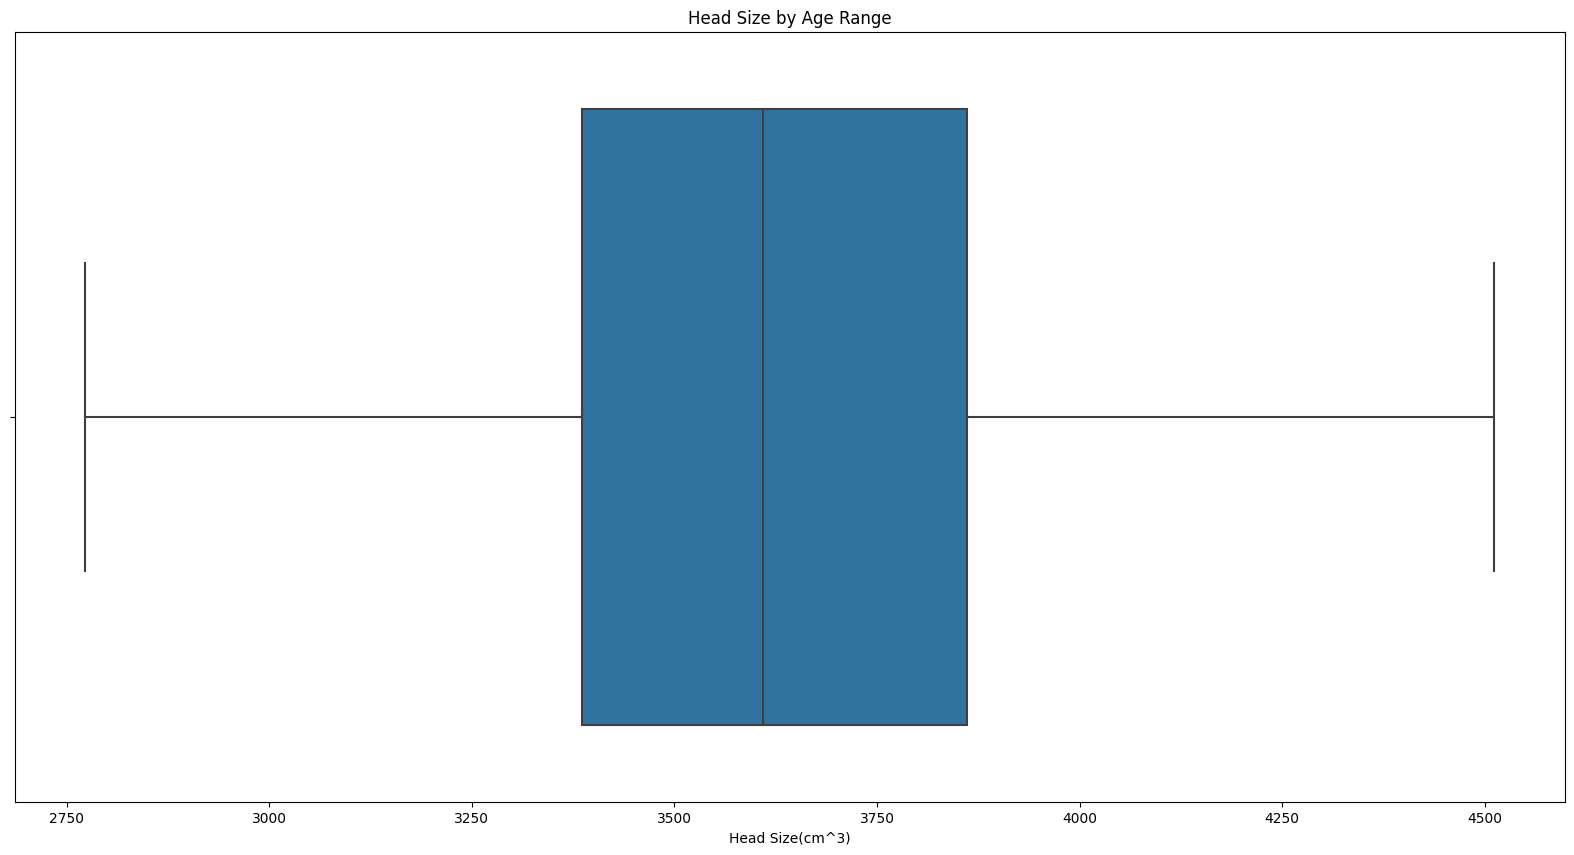

In [13]:
## Box plot of Head Size after IQR
sns.boxplot(x="Head Size(cm^3)", data=df_clean)
plt.title("Head Size by Age Range")
plt.show()

#### We see the outliers have been removed from the data without significant loss of data from 237 to 231

## Preprocessing the data
Since the data is cleaned, we will now preprocess data for our model to learn and perform better.

In [14]:
## Separating dependent and independent features or target variables
X = df_clean['Head Size(cm^3)'].values
y = df_clean['Brain Weight(grams)'].values

In [15]:
## Splitting data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Generally we use cross validation as a good practice but here we are going with simple test train split.

In [16]:
## Standardizing the data
def standardize_data(X_train, X_test):
    X_train_mean = np.mean(X_train)
    X_train_std = np.std(X_train)

    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std

    return X_train, X_test

In [17]:
X_train, X_test = standardize_data(X_train, X_test)

## ML model for the Dataset

#### Below are some functions about the algorithm which we will use.

In [18]:
## y = f(x) = w.X + b 
def predict_y(X, w, b):
    X = X.reshape(-1, 1)
    return np.dot(X, w) + b  # works for 1D and multi-D

In [19]:
def compute_coefficients(X_train, y_train):
  n = len(X_train)
  X_mean = np.mean(X_train)
  y_mean = np.mean(y_train)

  numerator = 0
  denominator = 0

  for i in range(n):
    numerator += (X_train[i] - X_mean) * (y_train[i] - y_mean)
    denominator += (X_train[i] - X_mean) ** 2

  slope = numerator / denominator
  intercept = y_mean - slope * X_mean

  return slope, intercept

In [20]:
def evaluate_ols(y_test, y_pred):
  mse = np.mean((y_test - y_pred) ** 2)
  rmse = np.sqrt(mse)
  r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
  return mse, rmse, r2

In [21]:
w, b = compute_coefficients(X_train, y_train)
y_pred = predict_y(X_test, w, b)

In [22]:
print(f"Coefficient of x or slope of f(x): {w},\n     y-intercept or constant term: {b}")

Coefficient of x or slope of f(x): 88.98403678905333,
     y-intercept or constant term: 1266.5194805194806


## Evaluation of Model

In [23]:
mse, rmse, r2 = evaluate_ols(y_test, y_pred)
print("MSE (Mean Squared Error): ", mse)
print("RMSE (Root Mean Squared Error): ", rmse)
print("R^2 (Coefficient of determination): ", r2)

MSE (Mean Squared Error):  18310.172721889543
RMSE (Root Mean Squared Error):  135.31508682290215
R^2 (Coefficient of determination):  -140.71000651085004


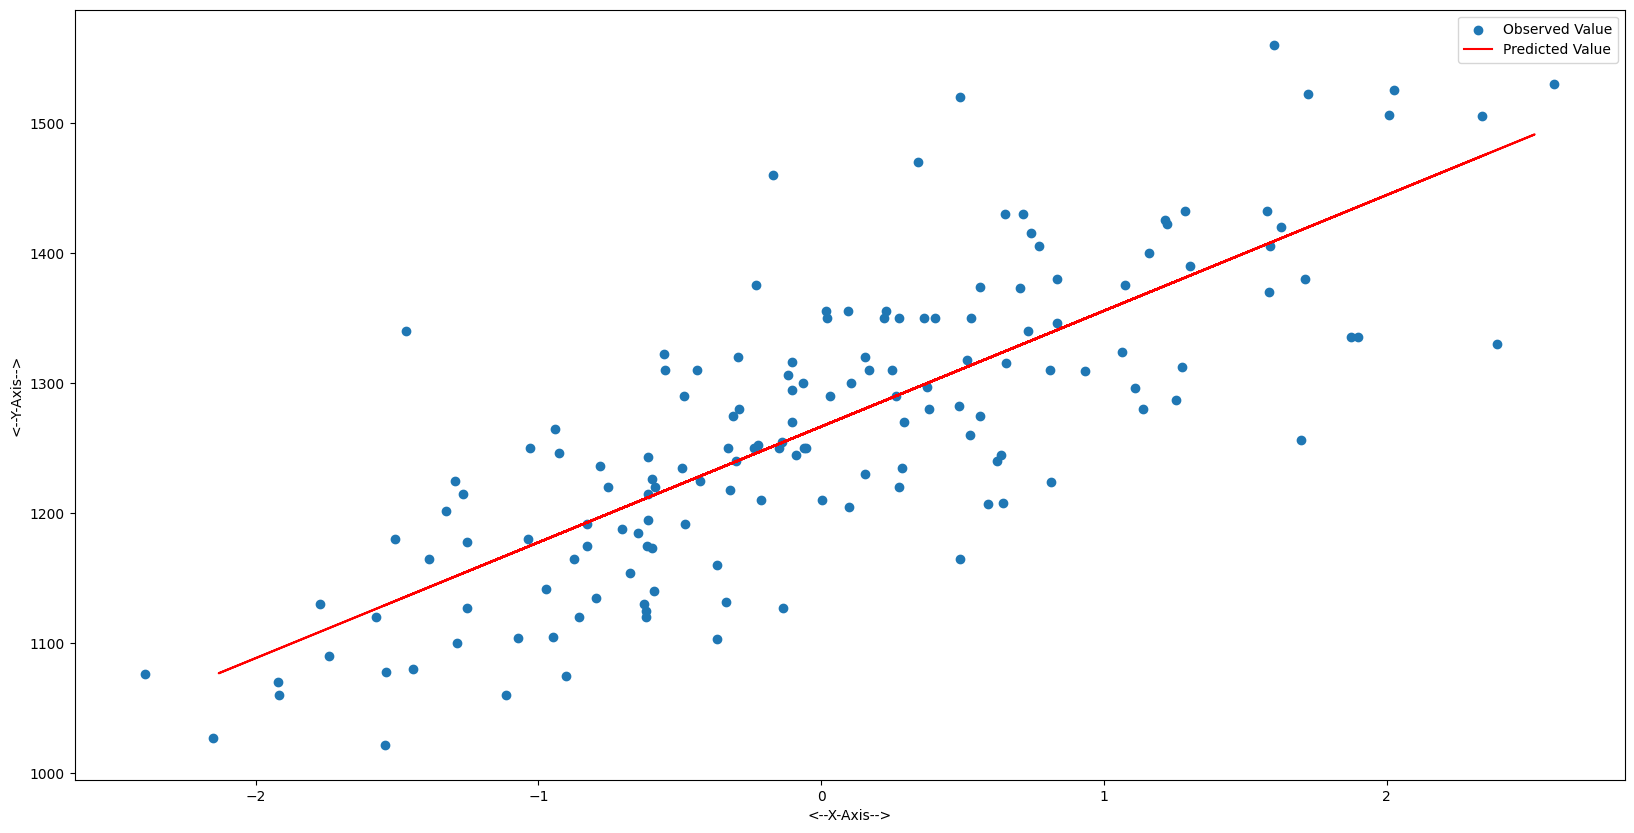

In [24]:
plt.scatter(X_train, y_train, label='Observed Value')
plt.plot(X_test, y_pred, label='Predicted Value', color='red')
plt.xlabel('<--X-Axis-->')
plt.ylabel('<--Y-Axis-->')
plt.legend()
plt.show()

## Minor Conclusion: 
- R^2 tells how much our model fits the data. Along with MSE and RMSE tells the error of predicted values of target and actual values of target.
- Looking at the values, our model is not that great and has not properly captured the data variance.
- Major reason for average performance is target value, Brain weight may depend on more features rather than brain size.
- Another reason may be less data and less information. I think.

## Using Gradient Descent Optimization

#### Below are some functions about the algorithm which we will use.

In [25]:
def initialize(num_features):
    w = np.random.rand(num_features)  # shape: (num_features)
    b = np.random.rand()
    return w, b

In [26]:
def compute_cost(y_true, y_pred):
    m = len(y_true)
    cost = (1 / (2 * m)) * np.sum((y_pred - y_true) ** 2)
    return cost

In [27]:
def update_parameters(X_train, y_true, y_pred, w, b, learning_rate):
    m = len(y_true)
    db = np.sum(y_pred - y_true) / m
    dw = np.dot(X_train.T, (y_pred - y_true)) / m  # shape (num_features,)
    w -= learning_rate * dw
    b -= learning_rate * db
    return w, b

In [28]:
def run_gradient_descent(X_train, y_true, learning_rate, epochs, stopping_threshold=1e-6):
    num_features = X_train.shape[1]  # number of columns
    w, b = initialize(num_features)
    previous_cost = None
    cost_history = []

    for epoch in range(epochs):
        y_pred = predict_y(X_train, w, b)
        cost = compute_cost(y_true, y_pred)

        cost_history.append(cost)  # storing cost each iteration for later visualization

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Cost: {cost:.6f} - Weights: {w} - Bias: {b:.4f}")

        # Early stopping
        if previous_cost and abs(previous_cost - cost) <= stopping_threshold:
            print(f"Early stopping at iteration {epoch+1} with cost change {abs(previous_cost - cost):.8f}")
            break

        previous_cost = cost

        # finally updating parameters
        w, b = update_parameters(X_train, y_true, y_pred, w, b, learning_rate)

    return w, b, cost_history

## Tuning Hyperparameters for Gradient Descent
A hyperparameter is something we set before training that controls the training process (it’s not learned from the data).
- Learning Rate
- Epochs

In [29]:
## Learning rate controls how big a step our gradient descent algorithm takes when updating model parameters (w and b)
learning_rate = 0.05
## Epochs tell our algorithm how many times to go through the full training dataset.
epochs = 5000 

## Training model with Gradient Descent

In [30]:
w, b, cost_history = run_gradient_descent(X_train.reshape(-1, 1), y_train, learning_rate, epochs)

Epoch 1/5000 - Cost: 807935.656329 - Weights: [0.20567713] - Bias: 0.3900
Epoch 2/5000 - Cost: 729401.084670 - Weights: [4.64459511] - Bias: 63.6964
Epoch 3/5000 - Cost: 658523.633748 - Weights: [8.8615672] - Bias: 123.8376
Epoch 4/5000 - Cost: 594556.734291 - Weights: [12.86769068] - Bias: 180.9717
Epoch 5/5000 - Cost: 536826.607530 - Weights: [16.67350798] - Bias: 235.2491
Epoch 6/5000 - Cost: 484725.168129 - Weights: [20.28903442] - Bias: 286.8126
Epoch 7/5000 - Cost: 437703.619070 - Weights: [23.72378454] - Bias: 335.7979
Epoch 8/5000 - Cost: 395266.671044 - Weights: [26.98679715] - Bias: 382.3340
Epoch 9/5000 - Cost: 356967.325450 - Weights: [30.08665913] - Bias: 426.5433
Epoch 10/5000 - Cost: 322402.166052 - Weights: [33.03152802] - Bias: 468.5421
Epoch 11/5000 - Cost: 291207.109695 - Weights: [35.82915346] - Bias: 508.4410
Epoch 12/5000 - Cost: 263053.571333 - Weights: [38.48689762] - Bias: 546.3449
Epoch 13/5000 - Cost: 237645.002961 - Weights: [41.01175458] - Bias: 582.3536
Ep

In [31]:
print(f"Learned weights: {w}")
print(f"Learned bias: {b}")
print(f"Final cost: {cost_history[-1]:.6f}")

Learned weights: [88.98374281]
Learned bias: 1266.5152879039617
Final cost: 2452.870093


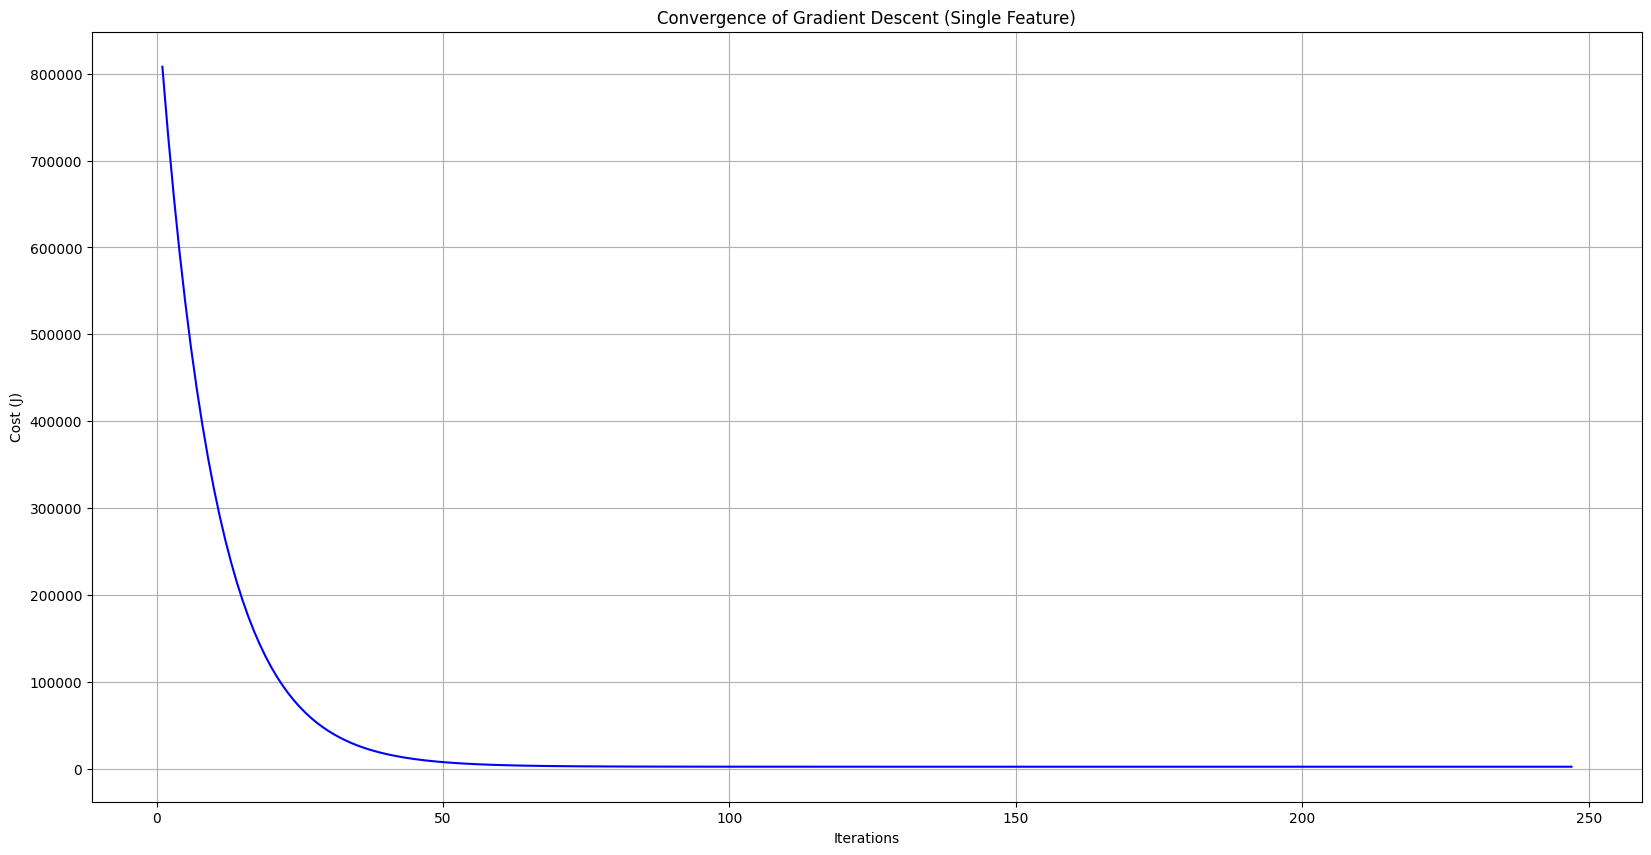

In [32]:
# Plotting convergence
plt.plot(range(1, len(cost_history) + 1), cost_history, color='blue')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Cost (J)')
plt.title('Convergence of Gradient Descent (Single Feature)')
plt.show()

## Final Results & Evaluation

In [33]:
y_pred = predict_y(X_test, w, b)
mse, rmse, r2 = evaluate_ols(y_test, y_pred)
print("MSE (Mean Squared Error): ", mse)
print("RMSE (Root Mean Squared Error): ", rmse)
print("R^2 (Coefficient of determination): ", r2)

MSE (Mean Squared Error):  3991.7973471484943
RMSE (Root Mean Squared Error):  63.18067225939033
R^2 (Coefficient of determination):  0.598776985144291


#### Not much difference through Gradient Descent too. 
#### BUT We should definitely try out other ML models with tweaks and other useful techniques while researching and experimenting as a great ML Engineer or a Data Scientist.

## Saving the Model

In [34]:
def save_model(w, b, learning_rate=None, convergence_tol=None, filename="linear_regression_model.pkl"):
    model_data = {
        'learning_rate': learning_rate,
        'convergence_tol': convergence_tol,
        'W': w,
        'b': b
    }
    with open(filename, 'wb') as file:
        pickle.dump(model_data, file)
    print(f"Model saved successfully to {filename}")

In [35]:
save_model(w=w, b=b, learning_rate=0.01, convergence_tol=1e-6, filename="my_lr_model.pkl")

Model saved successfully to my_lr_model.pkl


In [36]:
## Later we can load the model to use it.
with open("my_lr_model.pkl", "rb") as f:
    model = pickle.load(f)
print(model)

{'learning_rate': 0.01, 'convergence_tol': 1e-06, 'W': array([88.98374281]), 'b': 1266.5152879039617}


## Final Conclusion

### This project implemented Single Variable Linear Regression from scratch and applied it to the Head Size vs Brain Weight dataset.

### Key Findings
1. The correlation analysis showed a strong positive correlation between Head Size and Brain Weight, confirming that a linear model is a reasonable first choice.
2. The final model achieved:
    - MSE (Mean Squared Error):  3991.7974005400197
    - RMSE (Root Mean Squared Error):  63.18067268192085
    - R^2 (Coefficient of determination):  0.5987769797778089
3. This means the model explains about around 59.8% of the variance in brain weight from head size alone.

### Limitations
1. The dataset is small (n=237), which limits model generalization.
2. Categorical features like Gender and Age Range were present but had weak correlation with the target, so they were not strongly beneficial in this simple linear regression model.
3. The relationship between features and target is likely not purely linear — more complex patterns could be captured with polynomial features or non-linear models.

### Next Steps for Improvement
1. Try polynomial regression to capture non-linear relationships.
2. By Modeling and compare results with multiple regression using all available features.
3. Trying regularization (Ridge/Lasso) techniques.